In [66]:
import sys
import glob

import numpy as np
import matplotlib.pyplot as plt

import pandas as pd

import netCDF4 as nc

In [67]:
PATH = './data/pr_24hr_50yrs/'

In [68]:
nc_list = np.asarray(glob.glob(PATH+"*"))

In [69]:
dataset = nc.Dataset(nc_list[0])

In [70]:
dataset_list = np.asarray([nc.Dataset(path) for path in nc_list])

In [71]:
dataset_list.shape, nc_list.shape

((35,), (35,))

In [97]:
# Choose one random instance
# -------------------------- #
indx = np.random.randint(0, dataset_list.shape[0])
inst = dataset_list[indx]

In [98]:
inst['pr']

<class 'netCDF4._netCDF4.Variable'>
float64 pr(rlat, rlon)
    units: mm h-1
    _FillValue: nan
    long_name: 50-year 24-hour precipitation flux
unlimited dimensions: 
current shape = (124, 149)
filling on

In [100]:
inst['lat']

<class 'netCDF4._netCDF4.Variable'>
float64 lat(rlat, rlon)
    units: degrees_north
    _FillValue: nan
    long_name: latitude
unlimited dimensions: 
current shape = (124, 149)
filling on

In [87]:
rlat=inst.variables['rlat'][:]
rlon=inst.variables['rlon'][:]

In [88]:
rlat.shape, rlon.shape

((124,), (149,))

ValueError: x and y must have same first dimension, but have shapes (149,) and (124,)

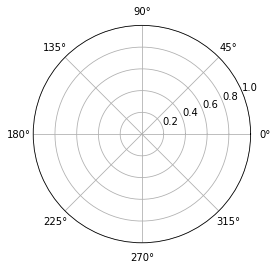

In [86]:
plt.polar(y, x, 'o')

In [52]:
x

<class 'netCDF4._netCDF4.Variable'>
float64 rlat(rlat)
    units: degrees
    long_name: latitude in rotated pole grid
unlimited dimensions: 
current shape = (124,)
filling on, default _FillValue of 9.969209968386869e+36 used